### HyperParameter tuning and choosing top 3 best performing alorithms

1. Evaluation and comparison of 10 ML algorithms across 9 performance metrics without tuning
2. Identification of suitable hyperparameters
3. Tuning hyperparameters
4. Evaluation and comparison of 10 ML algorithms across 9 performance metrics with tuning


* Input : Smote+TomekLink class balanced datasets - x_train_smtom.csv, y_train_smtom.csv, x_test_c4.csv and y_test_c4.csv
          Feature selected dataset for Tree based models - x_train_fs, x_test_fs
          Dimensionality reduced LDA fataset for non Tree based models - x_train_lda, x_test_lda
* Outcome : Gradient boosting(GBM), Logistic regression(LR) and Random Forest(RF) algorithms proved as best performing    algorithms after tuning.

In [1]:
from __future__ import print_function 
import time

# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import models from sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import cohen_kappa_score
from sklearn import model_selection

In [2]:
x_train=pd.read_csv('x_train_smtom.csv')
x_test=pd.read_csv('x_test_c4.csv')

y_train=pd.read_csv('y_train_smtom.csv')
y_test=pd.read_csv('y_test_c4.csv')

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(31664, 29) (9000, 29) (31664, 1) (9000, 1)


In [3]:
# Finalized set of significant features from feature selection methods

fs_set3=['LIMIT_BAL','PAY_AMT1', 'PAY_1', 'PAY_AMT2', 'AGE', 'SEX_2',
         'PAY_3', 'MARRIAGE_2', 'BILL_AMT1', 'MARRIAGE_1', 'PAY_2', 'SEX_1', 'EDUCATION_2', 'EDUCATION_1']

In [4]:
# Preparing data for Tree based models (As only feature selection works good for them)

x_train_fs = x_train[fs_set3]
x_test_fs = x_test[fs_set3]

print(x_train_fs.shape,x_test_fs.shape)

(31664, 14) (9000, 14)


In [5]:
# Data for non-tree based models (As only lDA works good for them)

# Make an instance of the Model
lda = LDA(n_components=1)

#Fitting on the training set only - both x and y. Apply the mapping (transform) to both the training set and the test set.
x_train_lda = lda.fit_transform(x_train, y_train)
x_test_lda = lda.transform(x_test)

#### Model Comparison and Evaluation

In [18]:
def models_comparison(x_train, y_train, x_test, y_test, folds):
    
    time_start = time.time()
    classifier_columns = []
    classifier_compare = pd.DataFrame(columns = classifier_columns)

    row_index = 0
    for alg in classifier:
    
        pred = alg.fit(x_train, y_train).predict(x_test)
        classifier_name = alg.__class__.__name__
        
        classifier_compare.loc[row_index,'ML Algorithm'] = classifier_name
        classifier_compare.loc[row_index, 'Train Accuracy'] = model_selection.cross_val_score(alg,x_train,y_train,cv=folds,scoring='accuracy').mean()        
        classifier_compare.loc[row_index, 'Test Accuracy'] = model_selection.cross_val_score(alg,x_test,y_test,cv=folds,scoring='accuracy').mean()
        classifier_compare.loc[row_index, 'Precision'] = model_selection.cross_val_score(alg,x_test,y_test,cv=folds,scoring='precision').mean()
        classifier_compare.loc[row_index, 'Recall'] = model_selection.cross_val_score(alg,x_test,y_test,cv=folds,scoring='recall').mean()
        classifier_compare.loc[row_index, 'F1 score'] = model_selection.cross_val_score(alg,x_test,y_test,cv=folds,scoring='f1').mean()
        fp, tp, th = roc_curve(y_test, pred)
        classifier_compare.loc[row_index, 'ROC AUC'] = auc(fp, tp)       
        classifier_compare.loc[row_index, 'Kappa'] = cohen_kappa_score(y_test, pred, labels=None, weights=None, sample_weight=None)  
        roc_auc = auc(fp, tp)
        classifier_compare.loc[row_index, 'GINI'] = (2 * roc_auc) - 1
        tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=[0,1]).ravel()
        classifier_compare.loc[row_index, 'Type II error'] = fn
        row_index+=1
    
    classifier_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)  
    print('Time elapsed: {} seconds'.format(time.time()-time_start))
    return classifier_compare

In [37]:
## ROC AUC curve comparison

classifier = [
    ensemble.AdaBoostClassifier(), ensemble.BaggingClassifier(), XGBClassifier(),
    ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), tree.DecisionTreeClassifier(),
    linear_model.LogisticRegressionCV(), naive_bayes.GaussianNB(), neighbors.KNeighborsClassifier(),svm.SVC(probability=True)
    ]

def roc_comparison(x_train, y_train, x_test, y_test):
    
    index = 1
    for alg in classifier:    

        pred = alg.fit(x_train, y_train).predict(x_test)
        fp, tp, th = roc_curve(y_test, pred)
        roc_auc = auc(fp, tp)
        classifier_name = alg.__class__.__name__
        plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (classifier_name, roc_auc))
        index+=1

    plt.title('ROC Curve comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()

### 1. Modelling tree based algorithms - SMOTE + Selected features (fs_set3)

In [16]:
# Considering only tree based algorithms

classifier = [
    ensemble.AdaBoostClassifier(), ensemble.BaggingClassifier(), XGBClassifier(),
    ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), tree.DecisionTreeClassifier()
    ]

In [19]:
comp_tree_models = models_comparison(x_train_fs, y_train, x_test_fs, y_test, 10)
comp_tree_models

Time elapsed: 218.57768630981445 seconds


,ML Algorithm,Train Accuracy,Test Accuracy,Precision,Recall,F1 score,ROC AUC,Kappa,GINI,Type II error
3,GradientBoostingClassifier,0.827703,0.826444,0.695588,0.348969,0.464344,0.674049,0.379679,0.348099,1088.0
0,AdaBoostClassifier,0.816145,0.824111,0.690314,0.335567,0.450882,0.660911,0.355732,0.321822,1142.0
4,RandomForestClassifier,0.846558,0.815778,0.635077,0.350515,0.448726,0.661112,0.342587,0.322225,1100.0
2,XGBClassifier,0.834021,0.810667,0.610752,0.341237,0.437355,0.653673,0.334275,0.307346,1147.0
1,BaggingClassifier,0.833168,0.801889,0.561655,0.319588,0.417804,0.641171,0.304479,0.282341,1176.0
5,DecisionTreeClassifier,0.791983,0.727889,0.366573,0.388144,0.374591,0.613411,0.207294,0.226822,1068.0


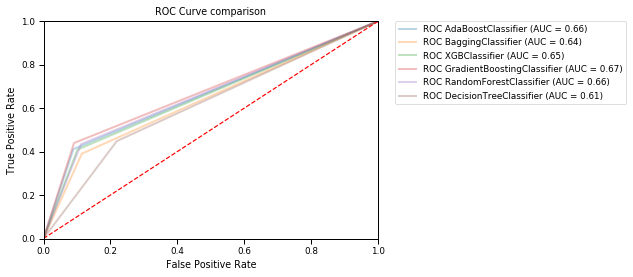

In [66]:
## Plotting ROC curve

roc_comparison(x_train_fs, y_train, x_test_fs, y_test)

### 2. Modelling non- tree based algorithms - SMOTE + LDA

In [67]:
# Considering non-tree based algorithms

classifier = [
    linear_model.LogisticRegressionCV(), naive_bayes.GaussianNB(), neighbors.KNeighborsClassifier(),svm.SVC(probability=True)
    ]

In [22]:
comp_nontree_models = models_comparison(x_train_lda, y_train, x_test_lda, y_test, 10)
comp_nontree_models

Time elapsed: 3462.978758573532 seconds


,ML Algorithm,Train Accuracy,Test Accuracy,Precision,Recall,F1 score,ROC AUC,Kappa,GINI,Type II error
3,SVC,0.850411,0.818667,0.666470,0.319072,0.431292,0.661217,0.373946,0.322434,1190.0
0,LogisticRegressionCV,0.851232,0.818444,0.696339,0.282474,0.401390,0.668582,0.376422,0.337163,1129.0
1,GaussianNB,0.845770,0.818333,0.662745,0.321134,0.432339,0.650220,0.359104,0.300441,1253.0
2,KNeighborsClassifier,0.832062,0.792222,0.531655,0.319072,0.398269,0.654620,0.326447,0.309240,1112.0


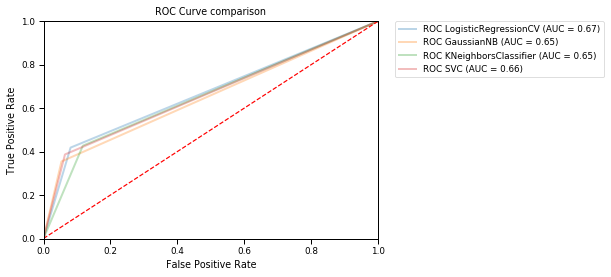

In [68]:
## Plotting ROC curve

roc_comparison(x_train_lda, y_train, x_test_lda, y_test)

### 3. Visualizing Modelling results without hyperparameter tuning

To Compare each of 10 ML classifiers against each evaluation metric to choose top 3 best classifiers

In [29]:
## Combining modelling metrics of tree based and non-tree based algorithms for visualizing comparisons
# Stacking the DataFrames on top of each other

fin_comp_notuning = pd.concat([comp_tree_models, comp_nontree_models], axis=0).sort_values(by=['ROC AUC','F1 score'], ascending=False)
fin_comp_notuning

,ML Algorithm,Train Accuracy,Test Accuracy,Precision,Recall,F1 score,ROC AUC,Kappa,GINI,Type II error
3,GradientBoostingClassifier,0.827703,0.826444,0.695588,0.348969,0.464205,0.674049,0.379679,0.348099,1088.0
0,LogisticRegressionCV,0.851232,0.818444,0.696339,0.282474,0.401390,0.668582,0.376422,0.337163,1129.0
3,SVC,0.850411,0.818667,0.666470,0.319072,0.431292,0.661217,0.373946,0.322434,1190.0
0,AdaBoostClassifier,0.816145,0.824111,0.690314,0.335567,0.450882,0.660911,0.355732,0.321822,1142.0
4,RandomForestClassifier,0.845989,0.813444,0.631293,0.354124,0.446819,0.660668,0.341846,0.321336,1102.0
2,KNeighborsClassifier,0.832062,0.792222,0.531655,0.319072,0.398269,0.654620,0.326447,0.309240,1112.0
2,XGBClassifier,0.834021,0.810667,0.610752,0.341237,0.437355,0.653673,0.334275,0.307346,1147.0
1,GaussianNB,0.845770,0.818333,0.662745,0.321134,0.432339,0.650220,0.359104,0.300441,1253.0
1,BaggingClassifier,0.836168,0.804444,0.570658,0.327835,0.412008,0.640205,0.301849,0.280409,1177.0
5,DecisionTreeClassifier,0.791415,0.730778,0.370906,0.389691,0.373229,0.613320,0.207412,0.226641,1070.0


Text(0.5, 1.0, 'Test Accuracy Comparison')

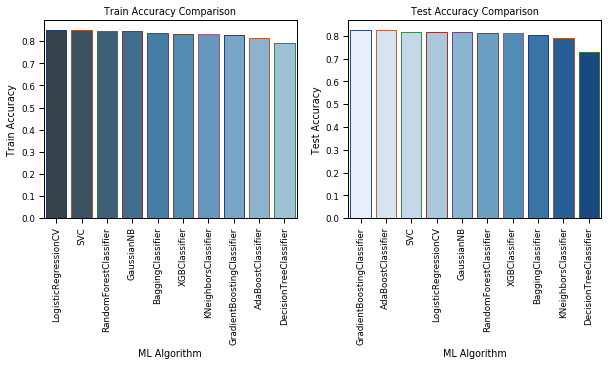

In [101]:
### 1. Comparing Train accuracy and Test accuracy among 10 classifiers

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.set_context('paper')
sns.barplot(x="ML Algorithm", y="Train Accuracy", data=fin_comp_notuning.sort_values(['Train Accuracy'], ascending=False),palette='Blues_d',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Train Accuracy Comparison') 

plt.subplot(2,2,2)
sns.set_context('paper')
sns.barplot(x="ML Algorithm", y="Test Accuracy", data=fin_comp_notuning.sort_values(['Test Accuracy'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Test Accuracy Comparison')  

Text(0.5, 1.0, 'Recall Comparison')

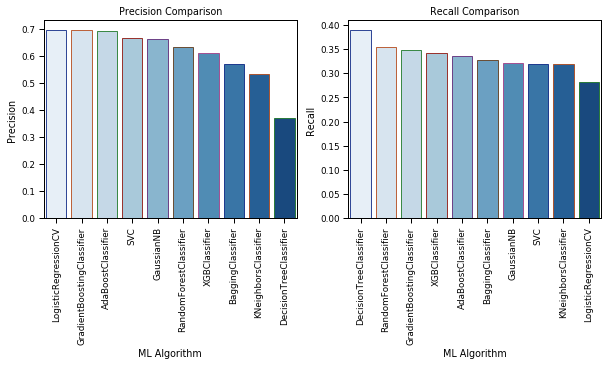

In [109]:
### 2. Comparing Precision and Recall among 10 classifiers

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.barplot(x="ML Algorithm", y="Precision", data=fin_comp_notuning.sort_values(['Precision'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Precision Comparison') 

plt.subplot(2,2,2)
sns.barplot(x="ML Algorithm", y="Recall", data=fin_comp_notuning.sort_values(['Recall'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Recall Comparison') 

Text(0.5, 1.0, 'AUC Comparison')

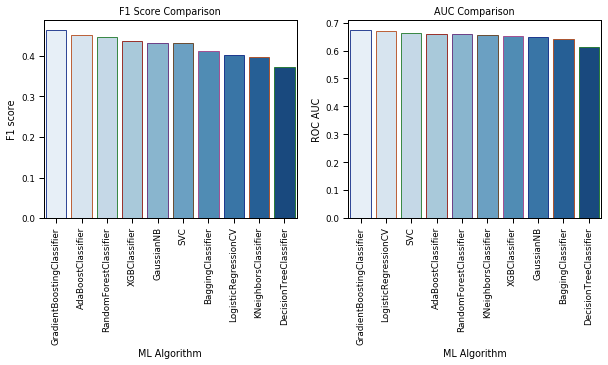

In [110]:
### 3. Comparing F1 score and AUC among 10 classifiers

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.barplot(x="ML Algorithm", y="F1 score", data=fin_comp_notuning.sort_values(['F1 score'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('F1 Score Comparison') 

plt.subplot(2,2,2)
sns.barplot(x="ML Algorithm", y="ROC AUC", data=fin_comp_notuning.sort_values(['ROC AUC'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('AUC Comparison') 

Text(0.5, 1.0, 'GINI Comparison')

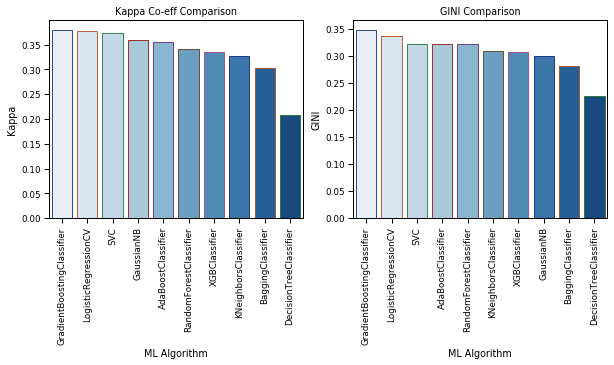

In [111]:
### 4. Comparing Kappa and GINI among 10 classifiers

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.barplot(x="ML Algorithm", y="Kappa", data=fin_comp_notuning.sort_values(['Kappa'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Kappa Co-eff Comparison') 

plt.subplot(2,2,2)
sns.barplot(x="ML Algorithm", y="GINI", data=fin_comp_notuning.sort_values(['GINI'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('GINI Comparison') 

### 3. Hyper Parameter tuning

#### 1. Identifying default parameters

To make sure default values are included in the range of parameter values

In [40]:
classifier = [
    ensemble.AdaBoostClassifier(), ensemble.BaggingClassifier(), XGBClassifier(),
    ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(), tree.DecisionTreeClassifier(),
    linear_model.LogisticRegressionCV(), naive_bayes.GaussianNB(), neighbors.KNeighborsClassifier(),svm.SVC(probability=True)
    ]

In [41]:
### Identifying default parameters for algorithms to make sure to include the default value in the ranges specified

def default_params():
    
    time_start = time.time()
    classifier_columns = []
    classifier_compare = pd.DataFrame(columns = classifier_columns)

    row_index = 0
    for alg in classifier:
        
        classifier_name = alg.__class__.__name__
        classifier_compare.loc[row_index,'ML Algorithm'] = classifier_name
        classifier_compare.loc[row_index,'Default parameters'] = str(alg.get_params())
        row_index+=1
    
    print('Time elapsed: {} seconds'.format(time.time()-time_start))
    return classifier_compare

In [42]:
pd.set_option('max_colwidth', -1)
default_params()

Time elapsed: 0.029923200607299805 seconds


,ML Algorithm,Default parameters
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
2,XGBClassifier,"{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}"
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}"
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
5,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}"
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}"
7,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}"
8,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}"
9,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"


#### 2. Selecting best hyperparameters using RandomizedSearchCV

Separate functions are used to tune hyperparameters for tree based and non-tree based algorithms considering having 2 different datasets for the same

In [86]:
# # classifiers
def hpo_DecisionTree(x_train, y_train):
    print('DecisionTree ...')
    tree = DecisionTreeClassifier(random_state=0)
    param_distributions = {
        'max_depth' : scipy.stats.randint(1,100),
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_split' : [2, 5, 10] 
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        tree,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_

def hpo_RandomForest(x_train, y_train):
    print('RandomForest ...')
    forest = RandomForestClassifier(random_state=0)
    param_distributions = {
        'criterion': ['gini','entropy'],
        'n_estimators' : scipy.stats.randint(50,1000),
        'min_samples_split': [2, 3, 5, 10], 
        'max_depth': [3, 5, 15, 25, 50],
        'max_features': [3, 5, 10, 20]
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        forest,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_

def hpo_Bagging(x_train, y_train):
    print('Bagging ...')
    bagging = BaggingClassifier(random_state=0)
    param_distributions = {
        'n_estimators' : scipy.stats.randint(1,200)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        bagging,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_

def hpo_AdaBoost(x_train, y_train):
    print('AdaBoost ...')
    adaboost = AdaBoostClassifier(random_state=0)
    param_distributions = {
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(30,200)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        adaboost,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_    

def hpo_XGBoost(x_train, y_train):
    print('XGBoost ...')
    xgboost = XGBClassifier(random_state=42)
    param_distributions = {
        "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
        "max_depth"        : [ 3, 4, 5, 6, 8, 10],
        "min_child_weight" : [ 1, 3, 5, 7 ],
        "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        xgboost,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_ 

def hpo_GradientBoost(x_train, y_train):
    print('Gradient Boosting ...')
    gboost = GradientBoostingClassifier(random_state=0)
    param_distributions = {
        'learning_rate' : [0.1, 0.05, 0.001],
        'n_estimators' : scipy.stats.randint(50,150),
        'subsample':[.5,.75,1],
        'max_depth': [2, 3, 5],
        'min_samples_split' : [0.1, 1, 2, 3]
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        gboost,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_ 

def hpo_KNN(x_train, y_train):
    print('K Nearest Neighbors ...')
    knn = KNeighborsClassifier()
    param_distributions = {
        'n_neighbors' : scipy.stats.randint(1,20),
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        knn,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_

def hpo_LogisticRegression(x_train, y_train):
    print('LogisticRegression ...')
    lr = LogisticRegression(random_state=0)
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 100.),
        'max_iter' : scipy.stats.randint(50,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        lr,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_

def hpo_GaussianNaiveBayes(x_train, y_train):
    print('Naive Bayes ...')
    gaussian = GaussianNB()
    param_distributions = {
        'var_smoothing' : scipy.stats.uniform(1e-10, 1e-9),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        gaussian,param_distributions,n_iter=10,cv=10,n_jobs=-1,random_state=0)
    randcv.fit(x_train, y_train)
    return randcv.best_estimator_ 

In [87]:
def hpo_models_tree(x_train, y_train, x_test, y_test):
    all_models = []
    model_names = []
    
    model4 = hpo_DecisionTree(x_train, y_train)
    all_models.append(model4)
    model_names.append('Decision Tree')

    model5 = hpo_RandomForest(x_train, y_train)
    all_models.append(model5)
    model_names.append('Random Forest')

    model6 = hpo_AdaBoost(x_train, y_train)
    all_models.append(model6)
    model_names.append('AdaBoost')

    model7 = hpo_XGBoost(x_train, y_train)
    all_models.append(model7)
    model_names.append('XGBoost')
    
    model8 = hpo_GradientBoost(x_train, y_train)
    all_models.append(model8)
    model_names.append('Gradient Boosting')
    
    model9 = hpo_Bagging(x_train, y_train)
    all_models.append(model9)
    model_names.append('Bagging')

    return all_models, model_names

In [88]:
def hpo_models_nontree(x_train, y_train, x_test, y_test):
    all_models = []
    model_names = []
    
    model1 = hpo_KNN(x_train, y_train)
    all_models.append(model1)
    model_names.append('KNN')

    model2 = hpo_LogisticRegression(x_train, y_train)
    all_models.append(model2)
    model_names.append('Logistic regression')
    
    model3 = hpo_GaussianNaiveBayes(x_train, y_train)
    all_models.append(model3)
    model_names.append('Gaussian Naive Bayes')

    return all_models, model_names

##### Selecting best hyperparameters for Tree-based algorithms

In [73]:
def hyper_params_tree(x_train, y_train, x_test, y_test):
    all_models, model_names = hpo_models_tree(x_train, y_train, x_test, y_test)
    return all_models, model_names

In [74]:
hyper_params_tree(x_train_fs, y_train, x_test_fs, y_test)

DecisionTree ...
RandomForest ...
AdaBoost ...
XGBoost ...
Gradient Boosting ...
Bagging ...


([DecisionTreeClassifier(max_depth=10, max_features='auto', random_state=0),
  RandomForestClassifier(max_depth=25, max_features=5, min_samples_split=5,
                         n_estimators=897, random_state=0),
  AdaBoostClassifier(learning_rate=1.5602148400639964, n_estimators=109,
                     random_state=0),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.15, max_delta_step=0, max_depth=10,
                min_child_weight=3, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  GradientBoostingClassifier(learning_rate=0.05, max_depth=5,
                

##### Selecting best hyperparameters for non Tree-based algorithms

In [89]:
def hyper_params_nontree(x_train, y_train, x_test, y_test):
    all_models, model_names = hpo_models_nontree(x_train, y_train, x_test, y_test)
    return all_models, model_names

In [ ]:
hyper_params_nontree(x_train_lda, y_train, x_test_lda, y_test)

#### 3. Tuning the model with above hyperparameters

##### Tuning tree based models

DecisionTree, RandomForest, AdaBoost, XGBoost, GBM and Bagging algorithms

In [91]:
classifier = [
    DecisionTreeClassifier(max_depth=10, max_features='auto', random_state=0),
  RandomForestClassifier(max_depth=25, max_features=5, min_samples_split=5,
                         n_estimators=897, random_state=0),
  AdaBoostClassifier(learning_rate=1.5602148400639964, n_estimators=109,
                     random_state=0),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.15, max_delta_step=0, max_depth=10,
                min_child_weight=3, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  GradientBoostingClassifier(learning_rate=0.05, max_depth=5,
                             min_samples_split=0.1, n_estimators=137,
                             random_state=0, subsample=1),
  BaggingClassifier(n_estimators=118, random_state=0)
]

In [82]:
comp_tree_models_tuned = models_comparison(x_train_fs, y_train, x_test_fs, y_test, 10)
comp_tree_models_tuned

Time elapsed: 2326.7333402633667 seconds


,ML Algorithm,Train Accuracy,Test Accuracy,Precision,Recall,F1 score,ROC AUC,Kappa,GINI,Type II error
4,GradientBoostingClassifier,0.829029,0.826111,0.688844,0.355155,0.468024,0.671437,0.368422,0.342874,1080.0
2,AdaBoostClassifier,0.818893,0.822333,0.674171,0.342784,0.453844,0.661469,0.360316,0.322939,1150.0
1,RandomForestClassifier,0.845863,0.819889,0.649907,0.358763,0.462007,0.662110,0.346637,0.324220,1103.0
3,XGBClassifier,0.840463,0.813667,0.625755,0.342784,0.442178,0.657519,0.342224,0.315039,1134.0
5,BaggingClassifier,0.845673,0.810889,0.605071,0.357732,0.449203,0.657609,0.334008,0.315217,1107.0
0,DecisionTreeClassifier,0.785508,0.808889,0.603856,0.333505,0.428511,0.643731,0.296896,0.287462,1121.0


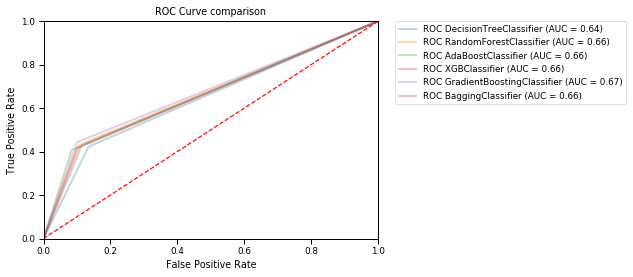

In [92]:
## Plotting ROC curve

roc_comparison(x_train_fs, y_train, x_test_fs, y_test)

##### Tuning non tree based models

SVM, Logistic regression, Naive Bayes and KNN

In [93]:
classifier = [
    SVC(probability=True,C=1),
    KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=19),
    LogisticRegression(C=44.30375245218265, max_iter=679, random_state=0),
    GaussianNB(var_smoothing=6.488135039273248e-10)
]

In [53]:
comp_nontree_models_tuned = models_comparison(x_train_lda, y_train, x_test_lda, y_test, 10)
comp_nontree_models_tuned

Time elapsed: 2201.757528066635 seconds


,ML Algorithm,Train Accuracy,Test Accuracy,Precision,Recall,F1 score,ROC AUC,Kappa,GINI,Type II error
2,LogisticRegression,0.851232,0.818667,0.682118,0.298454,0.414967,0.668582,0.376422,0.337163,1129.0
0,SVC,0.850411,0.818667,0.666470,0.319072,0.431292,0.661217,0.373946,0.322434,1190.0
3,GaussianNB,0.845770,0.818333,0.662745,0.321134,0.432339,0.650220,0.359104,0.300441,1253.0
1,KNeighborsClassifier,0.848926,0.815778,0.651446,0.316495,0.425042,0.663614,0.366707,0.327228,1148.0


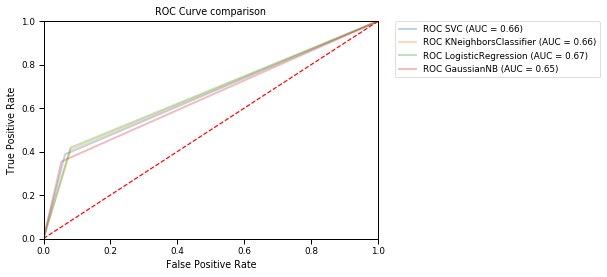

In [94]:
## Plotting ROC curve

roc_comparison(x_train_lda, y_train, x_test_lda, y_test)

#### 4. Visualizing Modelling results with hyperparameter tuning

In [95]:
## Combining modelling metrics of tree based and non-tree based algorithms for visualizing comparisons
# Stack the DataFrames on top of each other

fin_comp_tuned = pd.concat([comp_tree_models_tuned, comp_nontree_models_tuned], axis=0)
fin_comp_tuned

,ML Algorithm,Train Accuracy,Test Accuracy,Precision,Recall,F1 score,ROC AUC,Kappa,GINI,Type II error
4,GradientBoostingClassifier,0.829029,0.826111,0.688844,0.355155,0.468024,0.671437,0.368422,0.342874,1080.0
2,AdaBoostClassifier,0.818893,0.822333,0.674171,0.342784,0.453844,0.661469,0.360316,0.322939,1150.0
1,RandomForestClassifier,0.845863,0.819889,0.649907,0.358763,0.462007,0.662110,0.346637,0.324220,1103.0
3,XGBClassifier,0.840463,0.813667,0.625755,0.342784,0.442178,0.657519,0.342224,0.315039,1134.0
5,BaggingClassifier,0.845673,0.810889,0.605071,0.357732,0.449203,0.657609,0.334008,0.315217,1107.0
0,DecisionTreeClassifier,0.785508,0.808889,0.603856,0.333505,0.428511,0.643731,0.296896,0.287462,1121.0
2,LogisticRegression,0.851232,0.818667,0.682118,0.298454,0.414967,0.668582,0.376422,0.337163,1129.0
0,SVC,0.850411,0.818667,0.666470,0.319072,0.431292,0.661217,0.373946,0.322434,1190.0
3,GaussianNB,0.845770,0.818333,0.662745,0.321134,0.432339,0.650220,0.359104,0.300441,1253.0
1,KNeighborsClassifier,0.848926,0.815778,0.651446,0.316495,0.425042,0.663614,0.366707,0.327228,1148.0


Text(0.5, 1.0, 'Test Accuracy Comparison after Hyperparameter tuning')

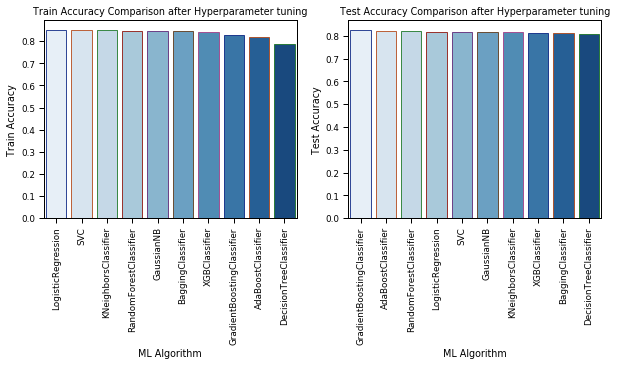

In [105]:
### 1. Comparing Train accuracy and Test accuracy among 10 classifiers

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.barplot(x="ML Algorithm", y="Train Accuracy", data=fin_comp_tuned.sort_values(['Train Accuracy'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Train Accuracy Comparison after Hyperparameter tuning') 

plt.subplot(2,2,2)
sns.barplot(x="ML Algorithm", y="Test Accuracy", data=fin_comp_tuned.sort_values(['Test Accuracy'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Test Accuracy Comparison after Hyperparameter tuning') 

Text(0.5, 1.0, 'Recall Comparison after Hyperparameter tuning')

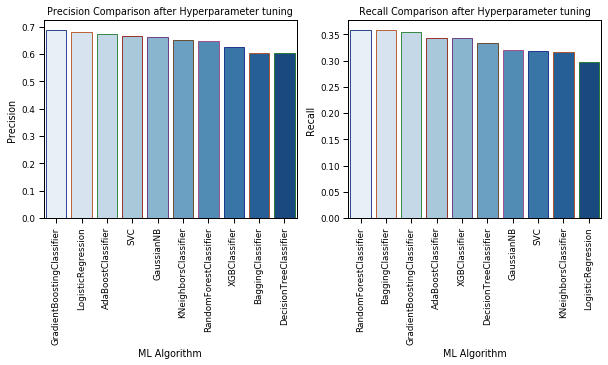

In [104]:
### 2. Comparing Precision and Recall among 10 classifiers

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.barplot(x="ML Algorithm", y="Precision", data=fin_comp_tuned.sort_values(['Precision'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Precision Comparison after Hyperparameter tuning') 

plt.subplot(2,2,2)
sns.barplot(x="ML Algorithm", y="Recall", data=fin_comp_tuned.sort_values(['Recall'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Recall Comparison after Hyperparameter tuning') 

Text(0.5, 1.0, 'AUC Comparison after Hyperparameter tuning')

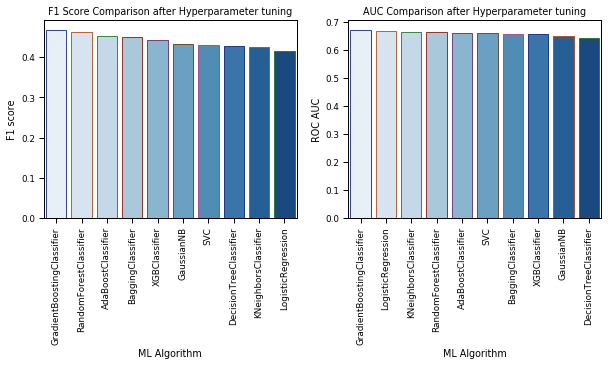

In [103]:
### 3. Comparing F1 score and AUC among 10 classifiers

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.barplot(x="ML Algorithm", y="F1 score", data=fin_comp_tuned.sort_values(['F1 score'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('F1 Score Comparison after Hyperparameter tuning') 

plt.subplot(2,2,2)
sns.barplot(x="ML Algorithm", y="ROC AUC", data=fin_comp_tuned.sort_values(['ROC AUC'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('AUC Comparison after Hyperparameter tuning') 

Text(0.5, 1.0, 'GINI Comparison after Hyperparameter tuning')

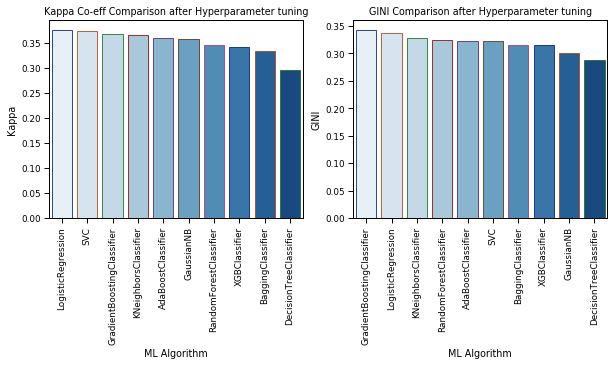

In [102]:
### 4. Comparing Kappa and GINI among 10 classifiers

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.barplot(x="ML Algorithm", y="Kappa", data=fin_comp_tuned.sort_values(['Kappa'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Kappa Co-eff Comparison after Hyperparameter tuning') 

plt.subplot(2,2,2)
sns.barplot(x="ML Algorithm", y="GINI", data=fin_comp_tuned.sort_values(['GINI'], ascending=False),palette='Blues',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('GINI Comparison after Hyperparameter tuning') 

#### Conclusion:

In [ ]:
# There is clear improvement of performance for Random Forest, KNN, Bagging and Decision tree  algorithms after tuning their
    # hyperparameters.

# Algorithms like GBM, XGboost, Adaboost, Naive Bayes, Logistic regression and SVM showed only a slight improvement in 
    # performance after tuning

# Considering the performance of all 10 algorithms against the 9 performance metrics, 
    # GBM, Logistic regression and Random Forest algorithms are considered as best performing algorithms